In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import sys
from pathlib import Path
project_root = Path.cwd().parent
sys.path.append(str(project_root))

from config.config import Config
from utils.helper_functions import create_X_y
from utils.visualization import plot_examples

In [2]:
class AnimalDataset(Dataset):
    """Custom Dataset class for binary classification"""
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X).permute(0, 3, 1, 2) / 255.0  # Change to (N, C, H, W) format and normalize
        self.y = torch.FloatTensor(y) 
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [3]:
class BinaryCNN(nn.Module):
    """CNN architecture for binary classification"""
    def __init__(self):
        super(BinaryCNN, self).__init__()
        
        # First convolutional block
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Calculate the size of flattened features
        flattened_size = 16 * (Config.IMG_SIZE//2) * (Config.IMG_SIZE//2)
        
        # Fully connected layers with single output for binary classification
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flattened_size, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.fc(x)
        return x.squeeze()

In [4]:
def train_binary_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    """Training function for binary classification"""
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                predicted = (outputs > 0.5).float()
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_loss = val_loss / len(val_loader)
        val_acc = 100 * correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        
        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        print('-' * 50)
    
    return train_losses, val_losses, train_accuracies, val_accuracies

In [5]:
def train_animal_classifier(X, y, animal_classes):
    """Function to train a binary classifier for a specific animal"""
    device = torch.device(Config.device)
    
    # Print dataset information
    print(f"Training classifier for {animal_classes[0]} vs {animal_classes[1]}")
    print(f"Dataset shape - X: {X.shape}, y: {y.shape}")
    print(f"Number of samples: {X.shape[0]}")
    print(f"Image size: {X[0].shape}")
    
    # Split data into train and validation sets
    train_size = int(0.8 * len(X))
    indices = np.random.permutation(len(X))
    
    train_indices = indices[:train_size]
    val_indices = indices[train_size:]
    
    X_train, y_train = X[train_indices], y[train_indices]
    X_val, y_val = X[val_indices], y[val_indices]
    
    # Create datasets and dataloaders
    train_dataset = AnimalDataset(X_train, y_train)
    val_dataset = AnimalDataset(X_val, y_val)
    
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    
    # Initialize model, loss function, and optimizer
    model = BinaryCNN().to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Train the model
    history = train_binary_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        num_epochs=50,
        device=device
    )
    
    return model, history


In [6]:
def main():
    # Define the classes
    tiger = ['tiger', 'Tiger_negative_class']
    elephant = ['elephant', 'Elephant_negative_class']
    fox = ['fox', 'Fox_negative_class']
    my_classes = [tiger, elephant, fox]
    
    # Dictionary to store models and their histories
    models = {}
    
    # Train a classifier for each animal
    for animal_class in my_classes:
        print(f"\nProcessing {animal_class[0]} classification...")
        X, y = create_X_y(animal_class)
        plot_examples(X, y)
        model, history = train_animal_classifier(X, y, animal_class)
        models[animal_class[0]] = (model, history)
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 2, 1)
        plt.plot(history[0], label='Train Loss')
        plt.plot(history[1], label='Val Loss')
        plt.title(f'{animal_class[0]} - Loss')
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.plot(history[2], label='Train Acc')
        plt.plot(history[3], label='Val Acc')
        plt.title(f'{animal_class[0]} - Accuracy')
        plt.legend()
        
        plt.tight_layout()
        plt.show()

    return models

In [7]:
""" models = main() """

' models = main() '

In [8]:
""" from utils.helper_functions import save_model
for animal, (model, history) in models.items():
    save_model(model, history, f"{animal}_baseline")
    print(f"Model for {animal}_baseline saved successfully!") """
    

' from utils.helper_functions import save_model\nfor animal, (model, history) in models.items():\n    save_model(model, history, f"{animal}_baseline")\n    print(f"Model for {animal}_baseline saved successfully!") '

In [9]:
from utils.helper_functions import load_model, evaluate_model
from utils.visualization import plot_model_performance, visualize_misclassified,plot_all_examples
tiger_model, tiger_history = load_model(BinaryCNN, 'tiger_baseline')

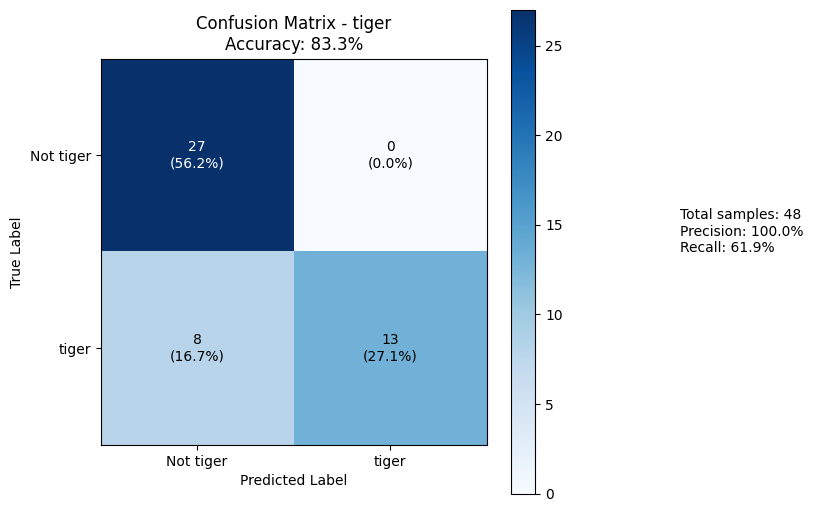


Model Predictions Shape: (48,)
True Labels Shape: (48,)

Detailed Metrics:
True Negatives: 27 (56.2%)
False Positives: 0 (0.0%)
False Negatives: 8 (16.7%)
True Positives: 13 (27.1%)


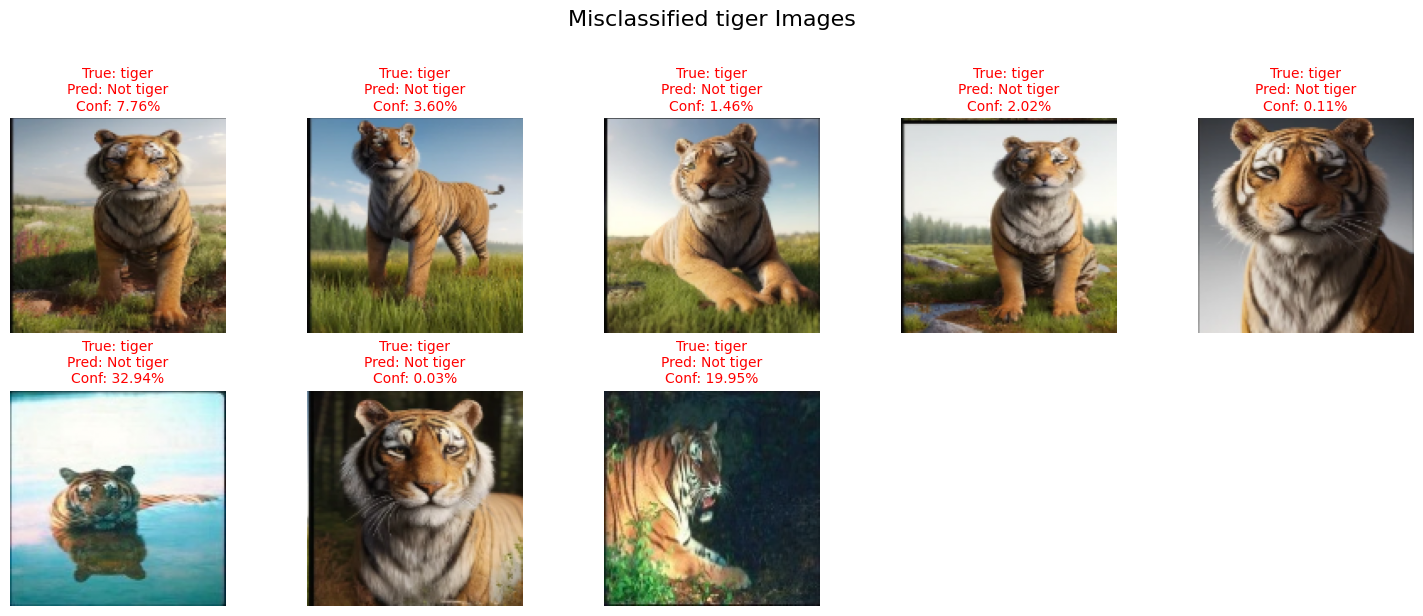


Error Analysis Summary:
Total misclassified images shown: 8
False Positives (incorrectly predicted as tiger): 0
False Negatives (incorrectly predicted as not tiger): 8


In [10]:
tiger = ['Tiger_negative _class_for_test', 'tiger_for_test']
X_test, y_test = create_X_y(tiger)
#print(y_test),

#plot_all_examples(X_test, y_test)

test_dataset = AnimalDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
# Plot performance metrics
plot_model_performance(tiger_model, test_loader, "tiger", Config.device)
visualize_misclassified(tiger_model, test_loader, "tiger", Config.device)


In [11]:
fox_model, fox_history = load_model(BinaryCNN, 'fox_baseline')

[0 1 0 0 1 1 1 0 1 0 1 0 1 0 1 1 1 1 0 0]


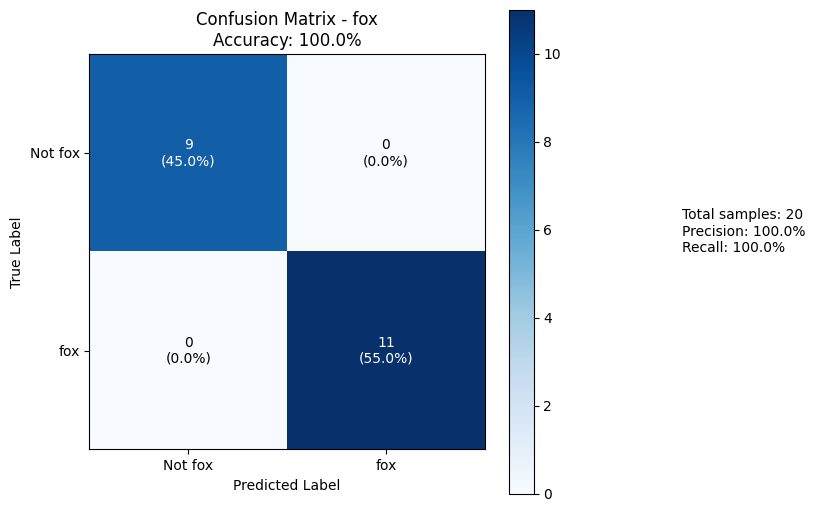


Model Predictions Shape: (20,)
True Labels Shape: (20,)

Detailed Metrics:
True Negatives: 9 (45.0%)
False Positives: 0 (0.0%)
False Negatives: 0 (0.0%)
True Positives: 11 (55.0%)
No misclassified images found!


In [12]:
fox = ['Fox_negative_class_for_test', 'fox_for_test']
X_test, y_test = create_X_y(fox)
print(y_test),

#plot_all_examples(X_test, y_test)

test_dataset = AnimalDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
# Plot performance metrics
plot_model_performance(fox_model, test_loader, "fox", Config.device)
visualize_misclassified(fox_model, test_loader, "fox", Config.device)

[0 1 1 1 0 1 1 0 0 1 0 0 1 1 1 1 0 0 1 1 0 0]


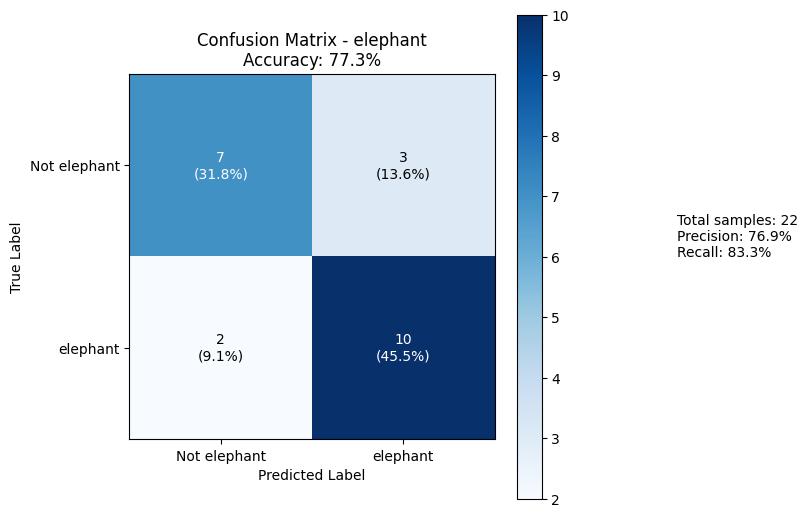


Model Predictions Shape: (22,)
True Labels Shape: (22,)

Detailed Metrics:
True Negatives: 7 (31.8%)
False Positives: 3 (13.6%)
False Negatives: 2 (9.1%)
True Positives: 10 (45.5%)


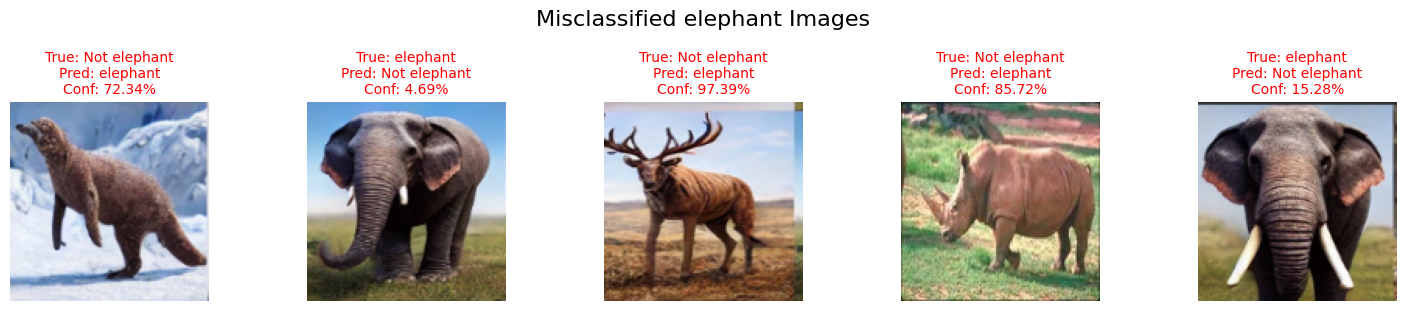


Error Analysis Summary:
Total misclassified images shown: 5
False Positives (incorrectly predicted as elephant): 3
False Negatives (incorrectly predicted as not elephant): 2


In [13]:
elephant_model, elephant_history = load_model(BinaryCNN, 'elephant_baseline')
elephant = ['Elephant_negative_class_for_test', 'elephant_for_test']
X_test, y_test = create_X_y(elephant)
print(y_test),

#plot_all_examples(X_test, y_test)

test_dataset = AnimalDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
# Plot performance metrics
plot_model_performance(elephant_model, test_loader, "elephant", Config.device)
visualize_misclassified(elephant_model, test_loader, "elephant", Config.device)